In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime

import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pmdarima as pm

# This will allow us to avoid a FutureWarning when plotting.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
daily = pd.read_csv('../Data/S00-USA-csv.csv')
daily.head()

,Date,Last,Settlement Price,Change,% Change,Bid,Ask,Open Interest,Volume
0,02/18/2020,8.932,8.938,0.000,0.00,8.930,8.932,"210,942.000","106,223.000"
1,02/14/2020,8.927,8.938,-0.025,-0.28,8.927,8.930,"232,144.000","130,575.000"
2,02/13/2020,8.958,8.962,0.037,0.42,8.955,8.960,"250,088.000","193,428.000"
3,02/12/2020,8.920,8.925,0.078,0.88,8.920,8.922,"277,418.000","163,370.000"
4,02/11/2020,8.850,8.847,0.005,0.06,8.850,8.852,"298,204.000","134,299.000"


In [ ]:
daily['Date'] = pd.to_datetime(daily['Date'])
daily.set_index('Date', inplace=True)
daily.sort_index(inplace=True)
daily

In [4]:
daily['Date'] = pd.to_datetime(daily['Date'])

In [5]:
daily.set_index('Date', inplace=True)

In [6]:
daily.sort_index(inplace=True)
daily

,Last,Settlement Price,Change,% Change,Bid,Ask,Open Interest,Volume
Date,,,,,,,,
1990-01-02,5.613,5.613,-0.067,-1.19,NaN,NaN,NaN,NaN
1990-01-03,5.673,5.673,0.060,1.07,NaN,NaN,NaN,NaN
1990-01-04,5.633,5.633,-0.040,-0.71,NaN,NaN,NaN,NaN
1990-01-05,5.645,5.645,0.012,0.22,NaN,NaN,NaN,NaN
1990-01-08,5.707,5.707,0.063,1.11,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-02-11,8.850,8.847,0.005,0.06,8.850,8.852,"298,204.000","134,299.000"
2020-02-12,8.920,8.925,0.078,0.88,8.920,8.922,"277,418.000","163,370.000"
2020-02-13,8.958,8.962,0.037,0.42,8.955,8.960,"250,088.000","193,428.000"


In [7]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7591 entries, 1990-01-02 to 2020-02-18
Data columns (total 8 columns):
Last                7582 non-null object
Settlement Price    7591 non-null float64
Change              7591 non-null float64
% Change            7591 non-null float64
Bid                 2511 non-null float64
Ask                 2489 non-null float64
Open Interest       4796 non-null object
Volume              4798 non-null object
dtypes: float64(5), object(3)
memory usage: 533.7+ KB


In [8]:
daily.isnull().sum().sort_values(ascending=False)

Ask                 5102
Bid                 5080
Open Interest       2795
Volume              2793
Last                   9
% Change               0
Change                 0
Settlement Price       0
dtype: int64

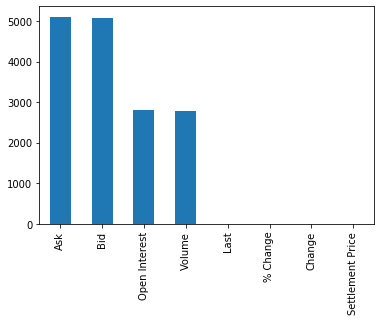

In [9]:
daily.isnull().sum().sort_values(ascending = False).plot(kind= 'bar')

In [10]:
daily['month'] = daily.index.month
daily['day'] = daily.index.day
daily['year'] = daily.index.year

In [11]:
daily[daily['Open Interest'].isnull()]['year'].value_counts()

1996    254
1992    254
1997    253
1993    253
1991    253
1990    253
1999    252
1995    252
2000    252
1998    252
1994    252
2001     13
2004      1
2002      1
Name: year, dtype: int64

Dropping years before 2002, to account for the Open Interest NA values. I will also remove 2020 data.

In [12]:
daily_mod = daily[daily['year']>2001]

In [13]:
daily_mod = daily_mod[daily_mod['year']<2020]

In [14]:
daily_mod.isnull().sum().sort_values(ascending = False)

Ask                 2074
Bid                 2052
Last                   4
Volume                 2
Open Interest          2
year                   0
day                    0
month                  0
% Change               0
Change                 0
Settlement Price       0
dtype: int64

In [15]:
daily_mod[daily_mod['Open Interest'].isnull()].index

DatetimeIndex(['2002-12-24', '2004-12-31'], dtype='datetime64[ns]', name='Date', freq=None)

In [16]:
index_mod = daily_mod[daily_mod['Open Interest'].isnull()].index

In [17]:
index_mod

DatetimeIndex(['2002-12-24', '2004-12-31'], dtype='datetime64[ns]', name='Date', freq=None)

In [18]:
daily_mod[daily_mod['year']==2002].tail(30)

,Last,Settlement Price,Change,% Change,Bid,Ask,Open Interest,Volume,month,day,year
Date,,,,,,,,,,,
2002-11-18,5.665,5.665,0.032,0.58,NaN,NaN,"82,041.000","28,527.000",11,18,2002
2002-11-19,5.738,5.738,0.073,1.28,NaN,NaN,"81,336.000","40,274.000",11,19,2002
2002-11-20,5.758,5.758,0.020,0.35,NaN,NaN,"83,842.000","37,207.000",11,20,2002
2002-11-21,5.695,5.695,-0.063,-1.09,NaN,NaN,"84,214.000","33,979.000",11,21,2002
2002-11-22,5.718,5.718,0.023,0.40,NaN,NaN,"82,536.000","35,887.000",11,22,2002
2002-11-25,5.722,5.722,0.005,0.09,NaN,NaN,"85,262.000","29,906.000",11,25,2002
2002-11-26,5.730,5.730,0.008,0.13,NaN,NaN,"84,784.000","23,163.000",11,26,2002
2002-11-27,5.773,5.773,0.043,0.74,NaN,NaN,"86,071.000","30,979.000",11,27,2002
2002-11-29,5.787,5.787,0.015,0.26,NaN,NaN,"88,142.000","18,868.000",11,29,2002


In [19]:
daily_mod[daily_mod['year']==2004].tail(30)

,Last,Settlement Price,Change,% Change,Bid,Ask,Open Interest,Volume,month,day,year
Date,,,,,,,,,,,
2004-11-18,5.550,5.550,0.020,0.36,NaN,NaN,"110,261.000","42,087.000",11,18,2004
2004-11-19,5.505,5.505,-0.045,-0.81,NaN,NaN,"106,719.000","39,653.000",11,19,2004
2004-11-22,5.545,5.545,0.040,0.73,NaN,NaN,"107,375.000","28,768.000",11,22,2004
2004-11-23,5.613,5.613,0.068,1.22,NaN,NaN,"106,545.000","38,866.000",11,23,2004
2004-11-24,5.540,5.540,-0.073,-1.29,NaN,NaN,"104,559.000","31,898.000",11,24,2004
2004-11-26,5.485,5.485,-0.055,-0.99,NaN,NaN,"105,774.000","26,536.000",11,26,2004
2004-11-29,5.395,5.395,-0.090,-1.64,NaN,NaN,"102,760.000","45,213.000",11,29,2004
2004-11-30,5.347,5.347,-0.048,-0.88,NaN,NaN,"102,606.000","40,697.000",11,30,2004
2004-12-01,5.280,5.280,-0.067,-1.26,NaN,NaN,"101,932.000","42,296.000",12,1,2004


12/24/2002 was Christmas Eve and 12/31/2004 was New Years Eve. Since the settlement price is the same as the prior day for both of these, I will fill the NA's with the values from the prior trading day.

In [20]:
daily_mod[daily_mod['Open Interest'].isnull()].index.unique()

DatetimeIndex(['2002-12-24', '2004-12-31'], dtype='datetime64[ns]', name='Date', freq=None)

In [21]:
daily_mod.loc

In [22]:
daily_mod.loc[index_mod[0]]= daily_mod.loc['2002-12-23']
daily_mod.loc[index_mod[1]]=daily_mod.loc['2004-12-30']

In [23]:
daily_mod.loc[index_mod[1]]=daily_mod.loc['2004-12-30']

In [24]:
daily_mod['Open Interest'].isnull().sum()

0

I will drop the columns I am not interesting in modeling: ['Last', 'Change', '% Change', 'Bid', 'Ask']

In [25]:
daily_mod.drop(columns = ['Last', 'Change', '% Change', 'Bid', 'Ask'], inplace = True)

In [26]:
daily_mod.isnull().sum().sort_values(ascending = False)

year                0
day                 0
month               0
Volume              0
Open Interest       0
Settlement Price    0
dtype: int64

Checking datatypes

In [27]:
daily_mod.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4531 entries, 2002-01-02 to 2019-12-31
Data columns (total 6 columns):
Settlement Price    4531 non-null float64
Open Interest       4531 non-null object
Volume              4531 non-null object
month               4531 non-null int64
day                 4531 non-null int64
year                4531 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 407.8+ KB


'Open Interest' and 'Volume' columns should be of type float so I will change these dtypes.

In [28]:
type(daily_mod['Open Interest'])

pandas.core.series.Series

In [29]:
daily_mod['Open Interest'].unique()

array(['73,058.000', '78,022.000', '77,528.000', ..., '340,301.000',
       '347,724.000', '362,098.000'], dtype=object)

removing characters preventing me from changing the datatype of 'Open Interest' and 'Volume' columns.

In [30]:
remove = [',', '.000']

for row in daily_mod.index:
    for i in remove:
        daily_mod['Open Interest'][row] = daily_mod['Open Interest'][row].replace(i, '')
        daily_mod['Volume'][row] = daily_mod['Volume'][row].replace(i, '')

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Changing datatypes.

In [31]:
daily_mod[['Open Interest', 'Volume']] = daily_mod[['Open Interest', 'Volume']].astype(int)

In [32]:
daily_mod.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4531 entries, 2002-01-02 to 2019-12-31
Data columns (total 6 columns):
Settlement Price    4531 non-null float64
Open Interest       4531 non-null int64
Volume              4531 non-null int64
month               4531 non-null int64
day                 4531 non-null int64
year                4531 non-null int64
dtypes: float64(1), int64(5)
memory usage: 407.8 KB


In [33]:
daily_mod.describe()

,Settlement Price,Open Interest,Volume,month,day,year
count,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000
mean,9.614234,233486.741117,87235.192011,6.545796,15.731406,2010.497462
std,2.927562,98087.830628,40260.587783,3.425629,8.746922,5.188813
min,4.182000,30568.000000,545.000000,1.000000,1.000000,2002.000000
25%,7.453500,145933.500000,56819.000000,4.000000,8.000000,2006.000000
50%,9.517000,234481.000000,84219.000000,7.000000,16.000000,2010.000000
75%,11.571500,311075.000000,110131.000000,10.000000,23.000000,2015.000000
max,17.683000,445389.000000,352462.000000,12.000000,31.000000,2019.000000


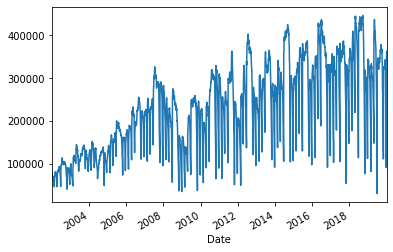

In [34]:
daily_mod['Open Interest'].plot()

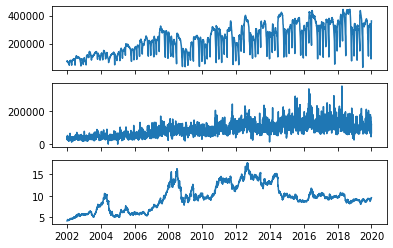

In [35]:
f, (ax1, ax2, ax3)= plt.subplots(3, 1, sharex=True)
ax1.plot(daily_mod['Open Interest'])
ax2.plot(daily_mod['Volume'])
ax3.plot(daily_mod['Settlement Price'])


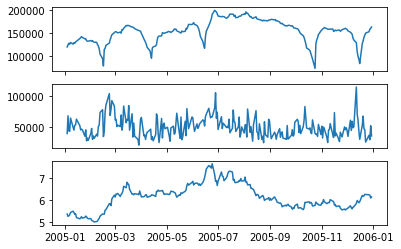

In [36]:
f, (ax1, ax2, ax3)= plt.subplots(3, 1, sharex=True)
ax1.plot(daily_mod[daily_mod['year']==2005]['Open Interest'])
ax2.plot(daily_mod[daily_mod['year']==2005]['Volume'])
ax3.plot(daily_mod[daily_mod['year']==2005]['Settlement Price'])


In [37]:
pivot_av = pd.pivot_table(daily_mod, 
               columns = ['year'],
               index = ['month'],
               values = ['Settlement Price', 'Open Interest', 'Volume']
              )

In [38]:
from matplotlib import cm

In [39]:
'b1', 'g1', 'r1', 'c1', 'm1', 'y1', 'k1', 'w1

SyntaxError: EOL while scanning string literal (<ipython-input-39-1f2454a5a0d0>, line 1)

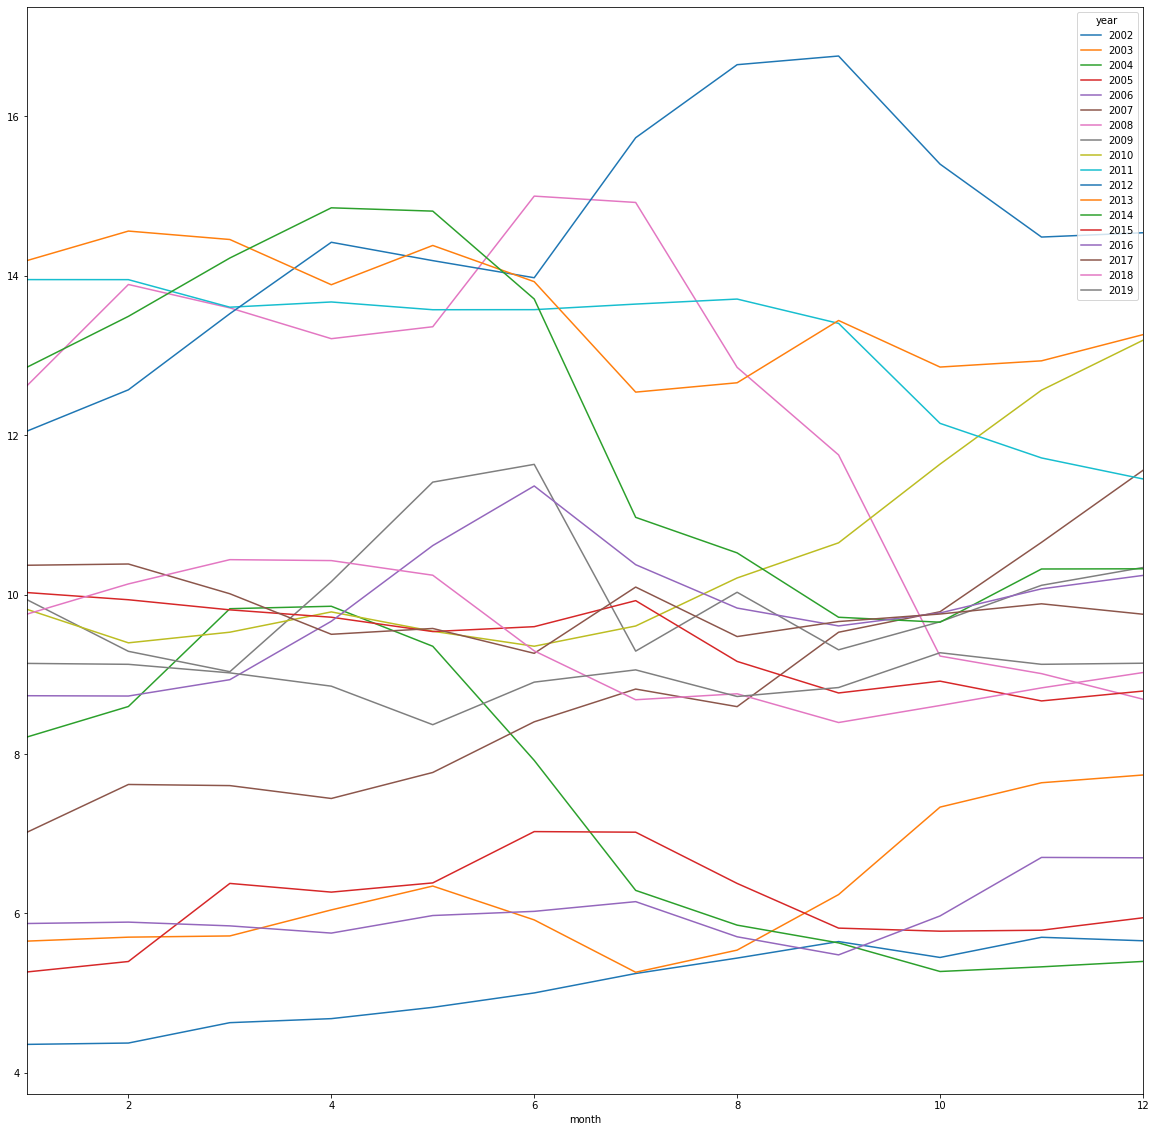

In [40]:
pivot_av['Settlement Price'].plot(figsize = (20,20),
                                  kind = 'line'
                                 )

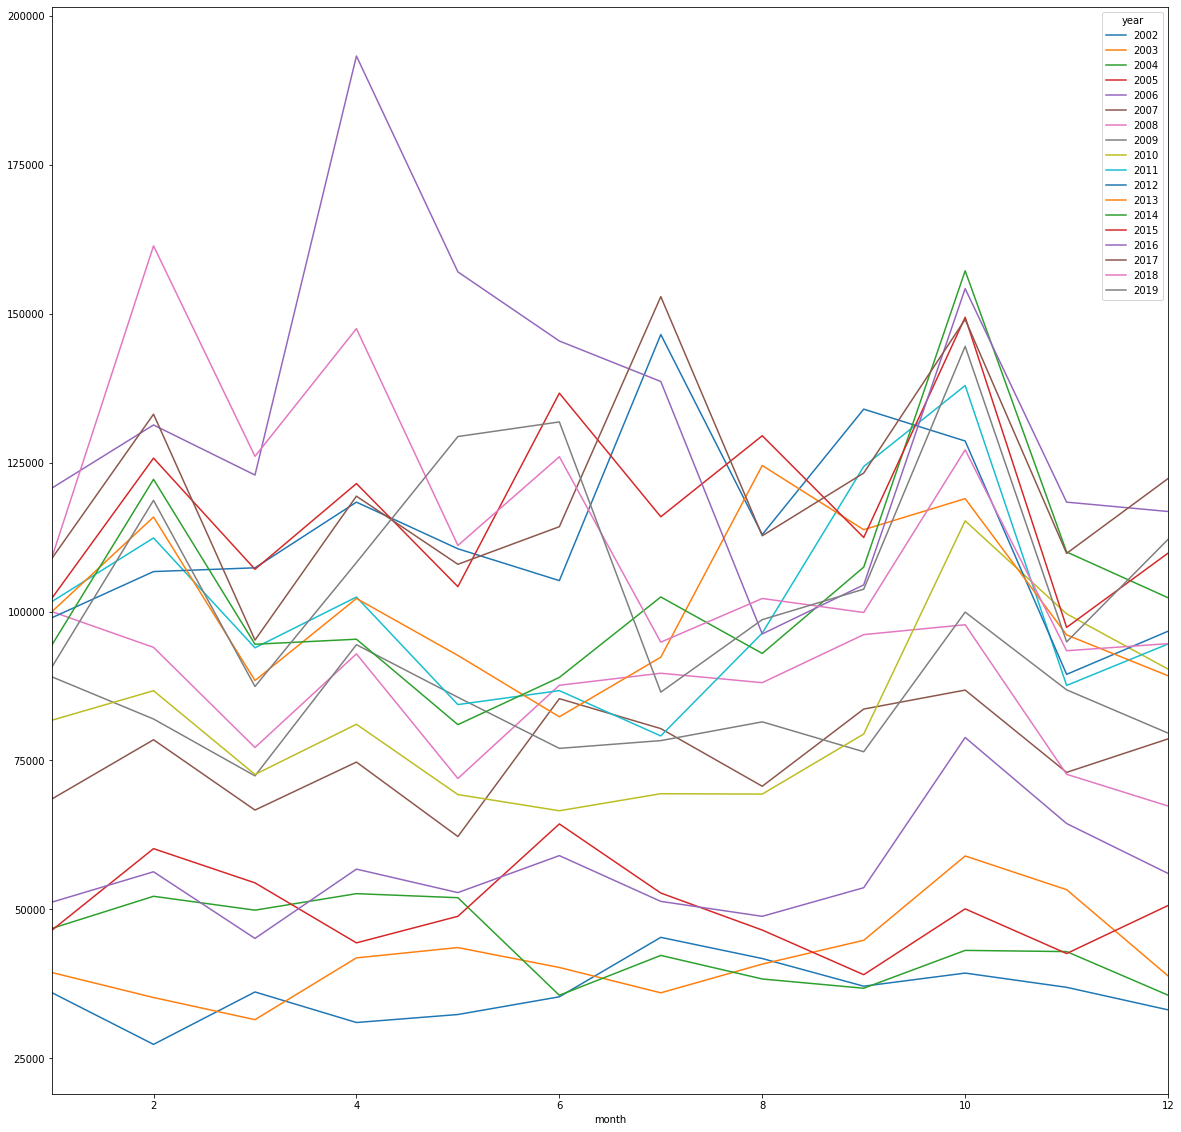

In [41]:
pivot_av['Volume'].plot(figsize = (20,20),
                                  kind = 'line')

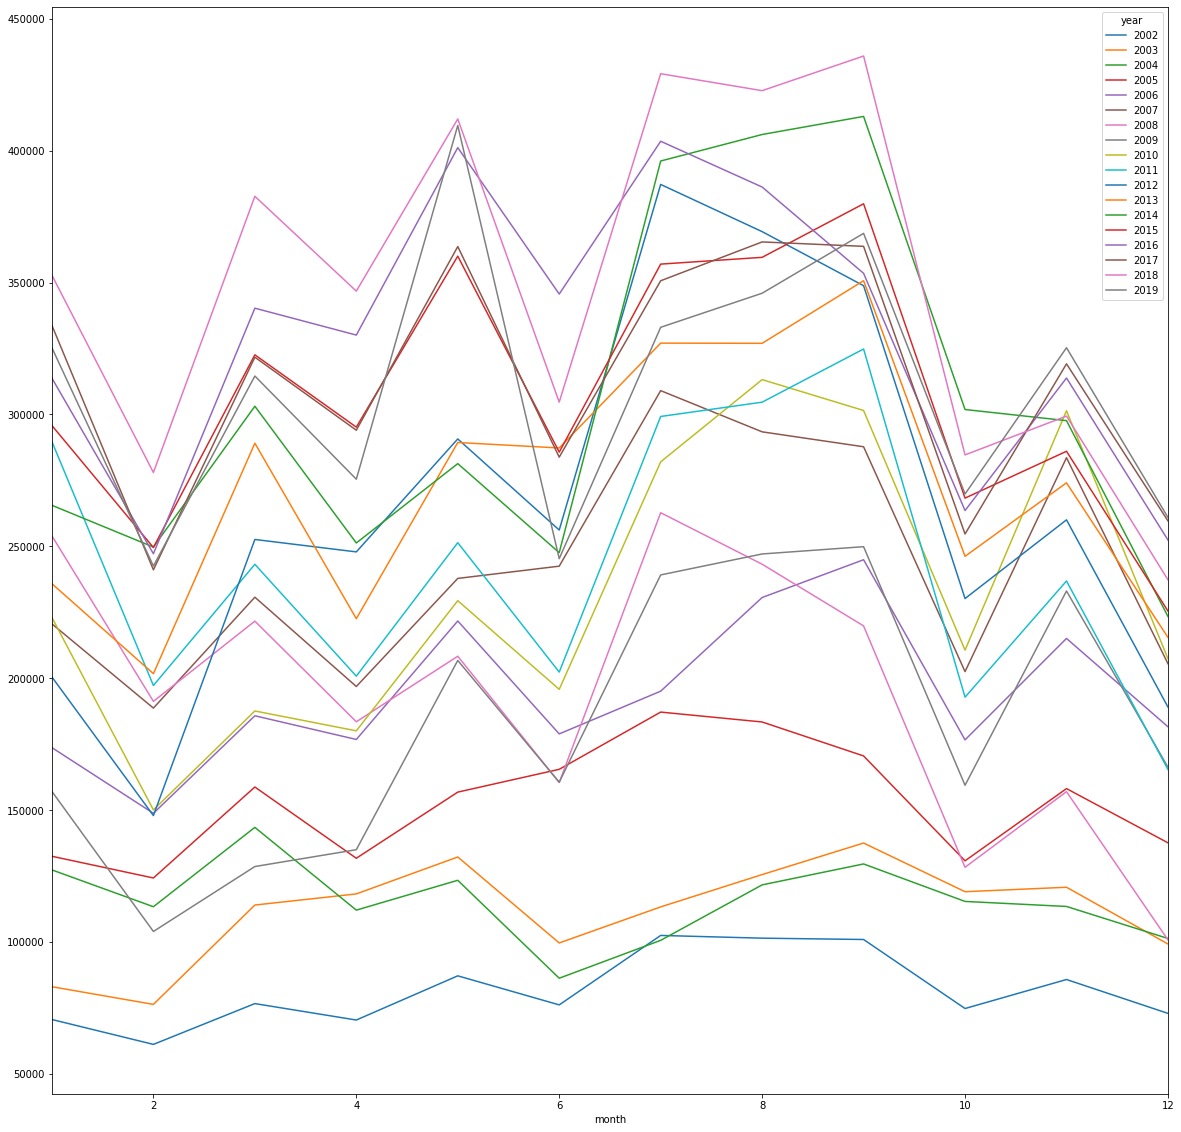

In [42]:
pivot_av['Open Interest'].plot(figsize = (20,20),
                                  kind = 'line')

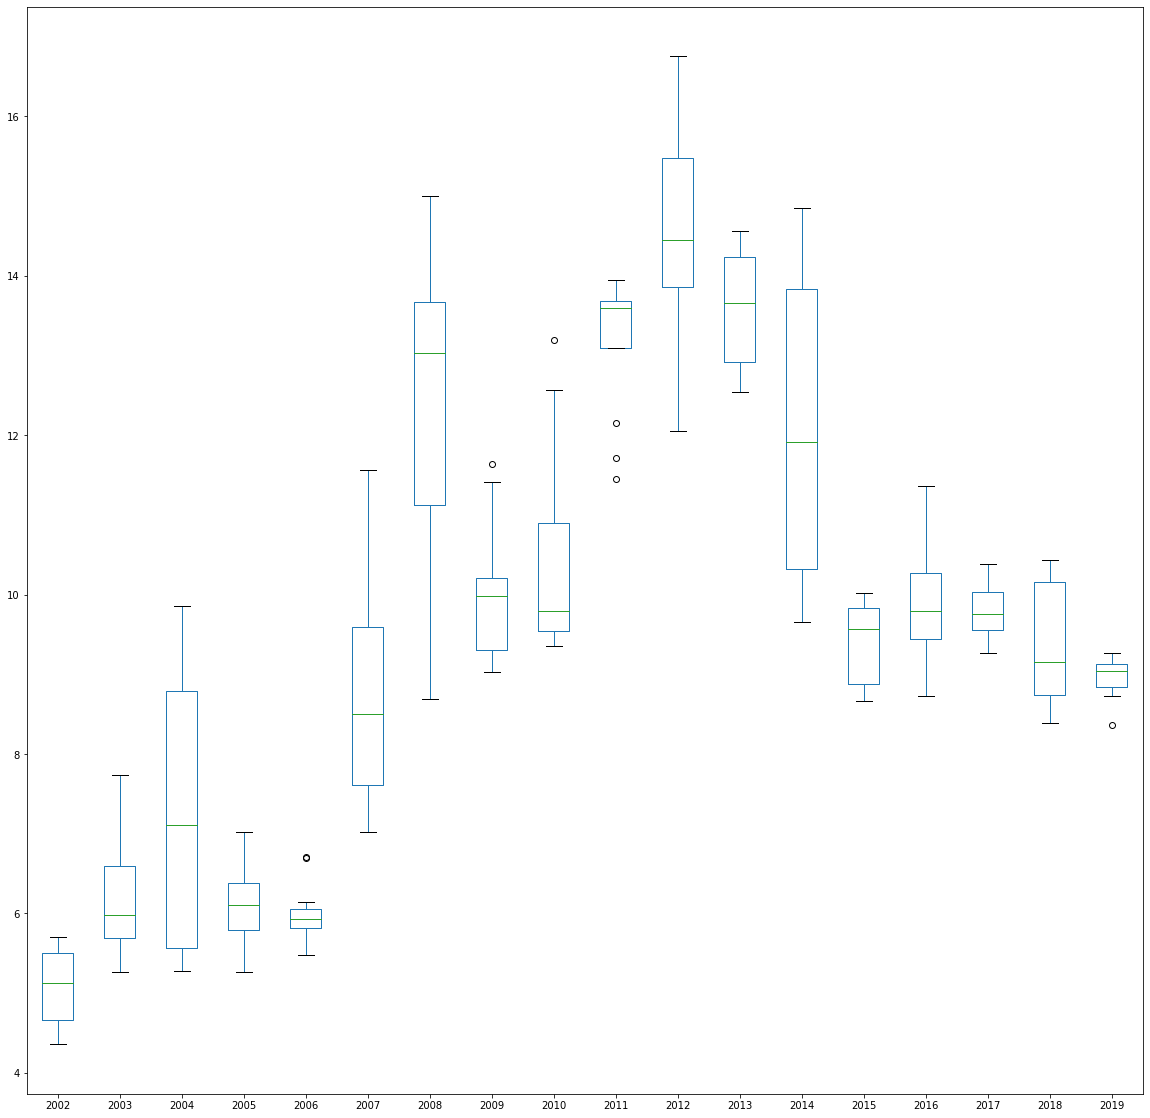

In [43]:
pivot_av['Settlement Price'].plot(figsize = (20,20),
                                  kind = 'box')

Text(0.5, 1.0, 'Density Function of Annual Settlement Prices')

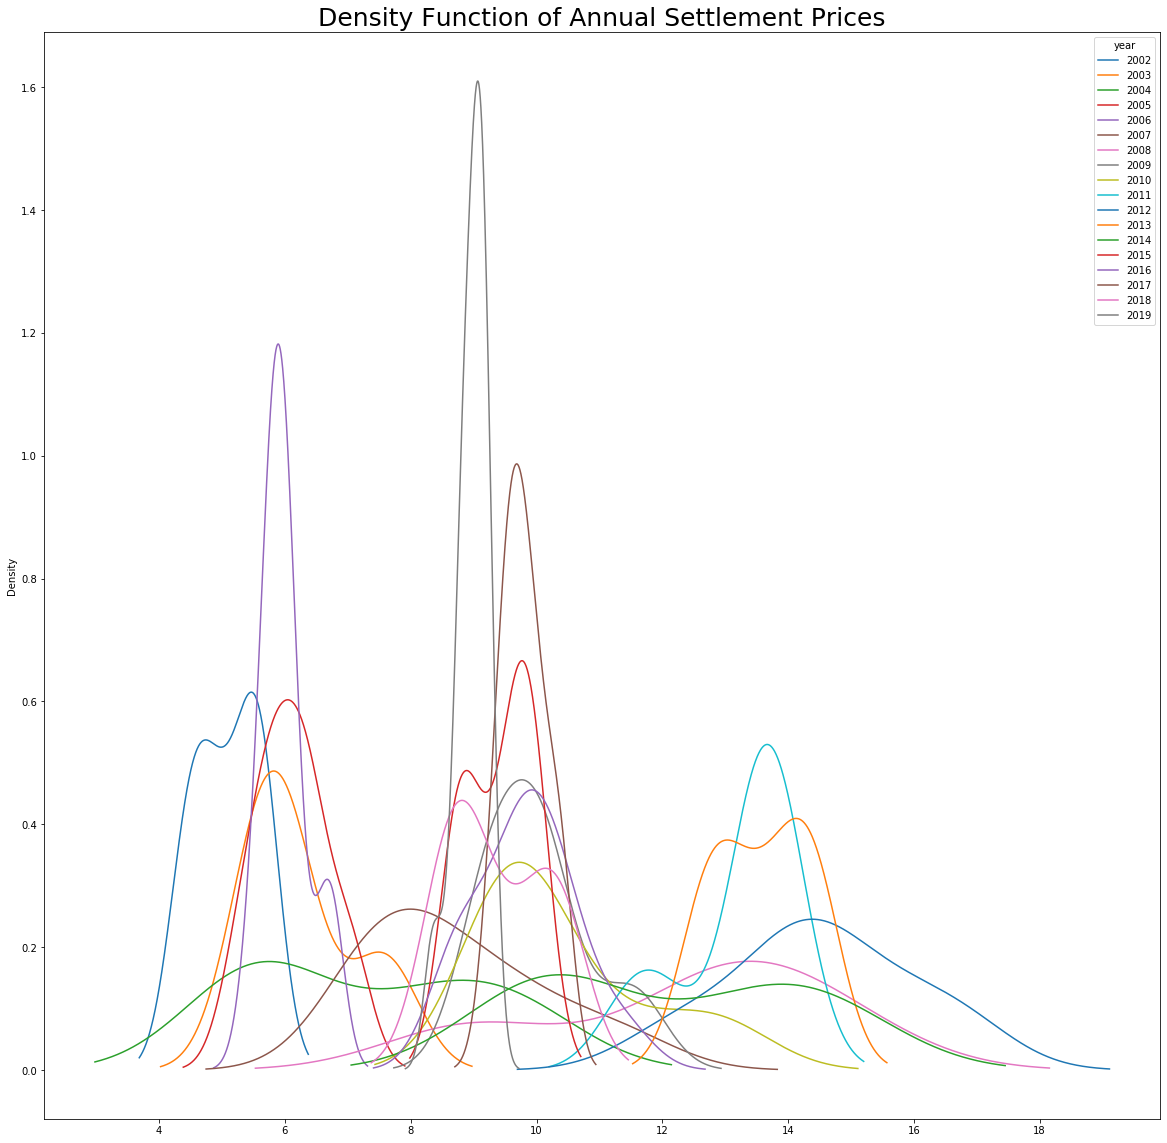

In [44]:
pivot_av['Settlement Price'].plot(figsize = (20,20),
                                  kind = 'kde')
plt.title('Density Function of Annual Settlement Prices', fontsize = 25)

Text(0.5, 1.0, 'Density Function of Monthly Settlement Prices')

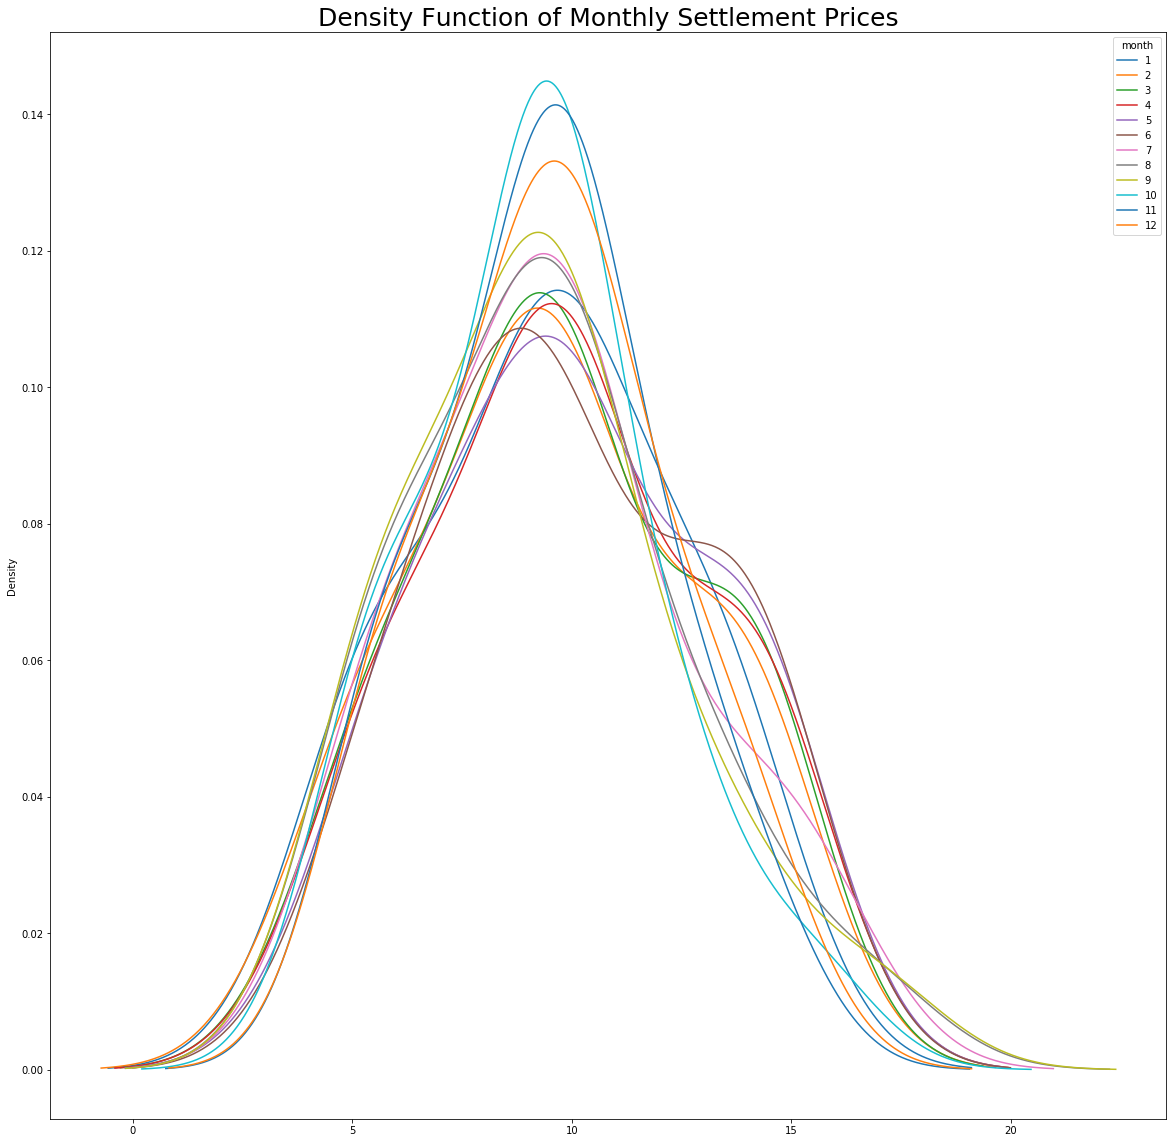

In [48]:
pivot_av_mod['Settlement Price'].plot(figsize = (20,20),
                                  kind = 'kde')
plt.title('Density Function of Monthly Settlement Prices', fontsize = 25)

In [47]:
pivot_av_mod = pd.pivot_table(daily_mod, 
               columns = ['month'],
               index = ['year'],
               values = ['Settlement Price', 'Open Interest', 'Volume']
              )

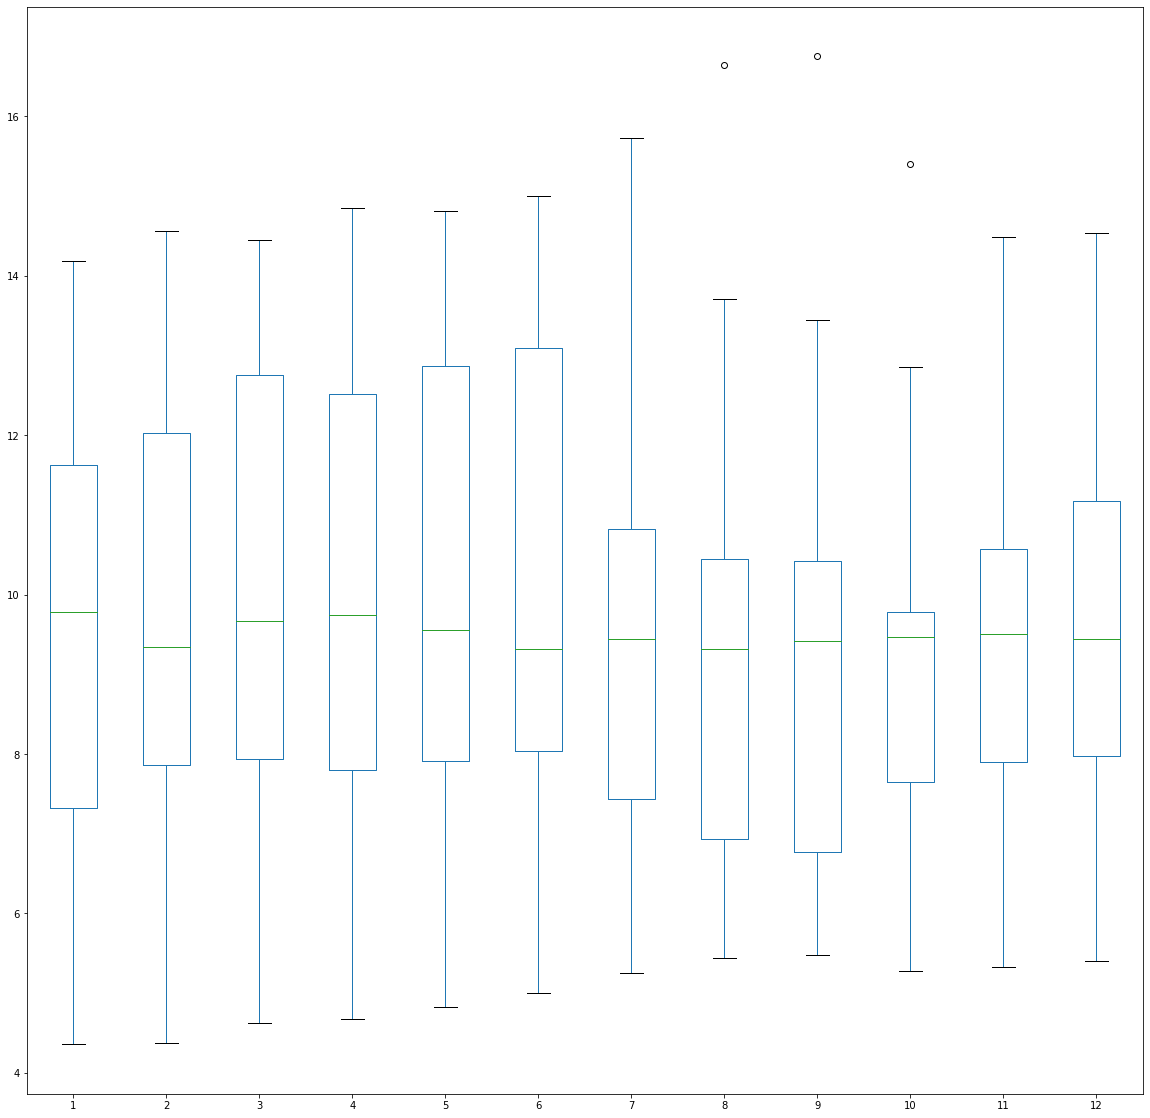

In [49]:
pivot_av_mod['Settlement Price'].plot(figsize = (20,20),
                                  kind = 'box')

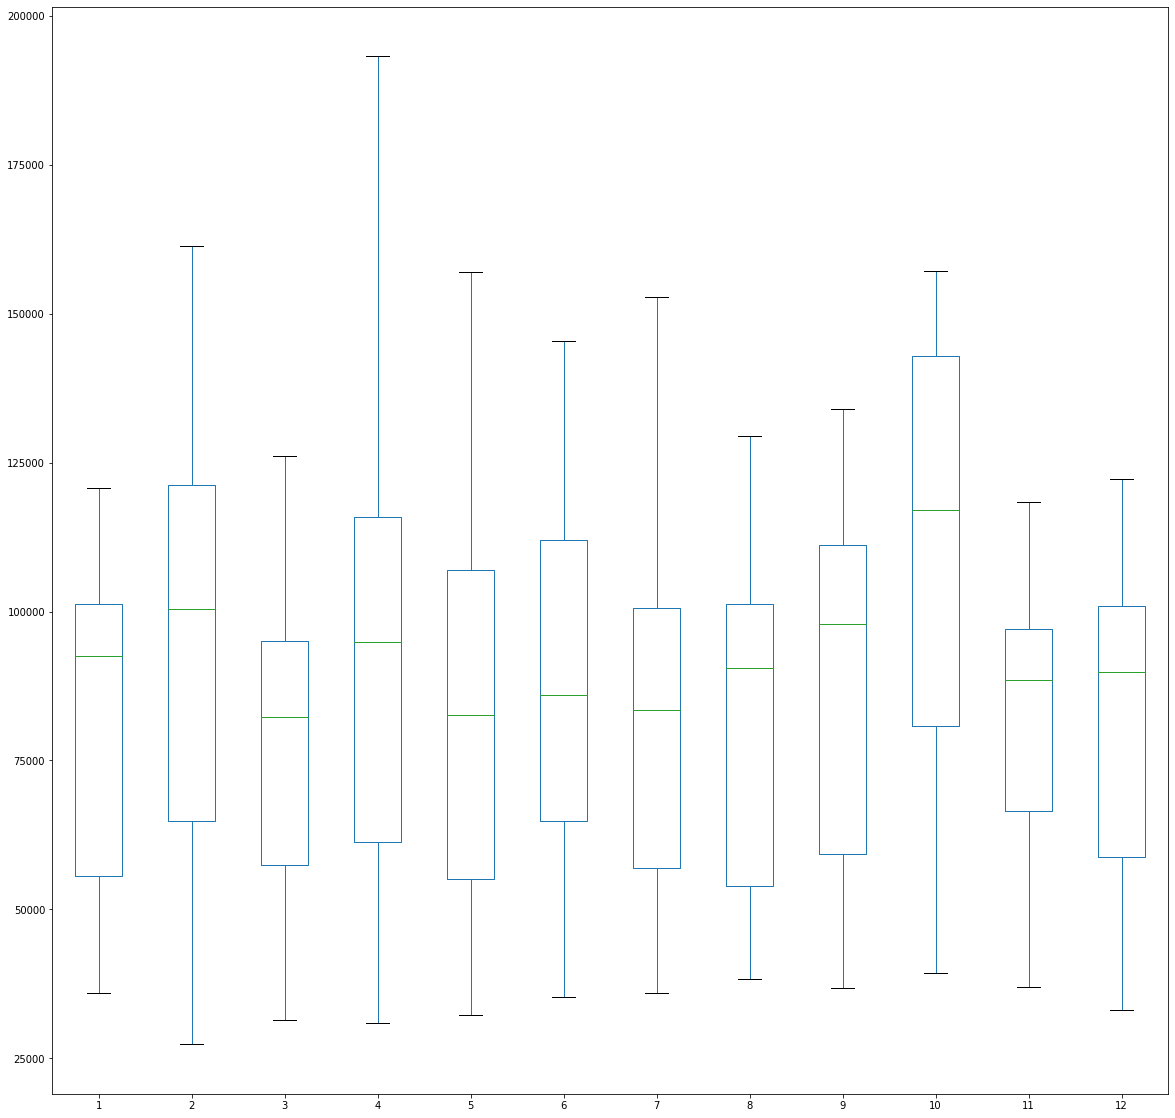

In [50]:
pivot_av_mod['Volume'].plot(figsize = (20,20),
                                  kind = 'box')

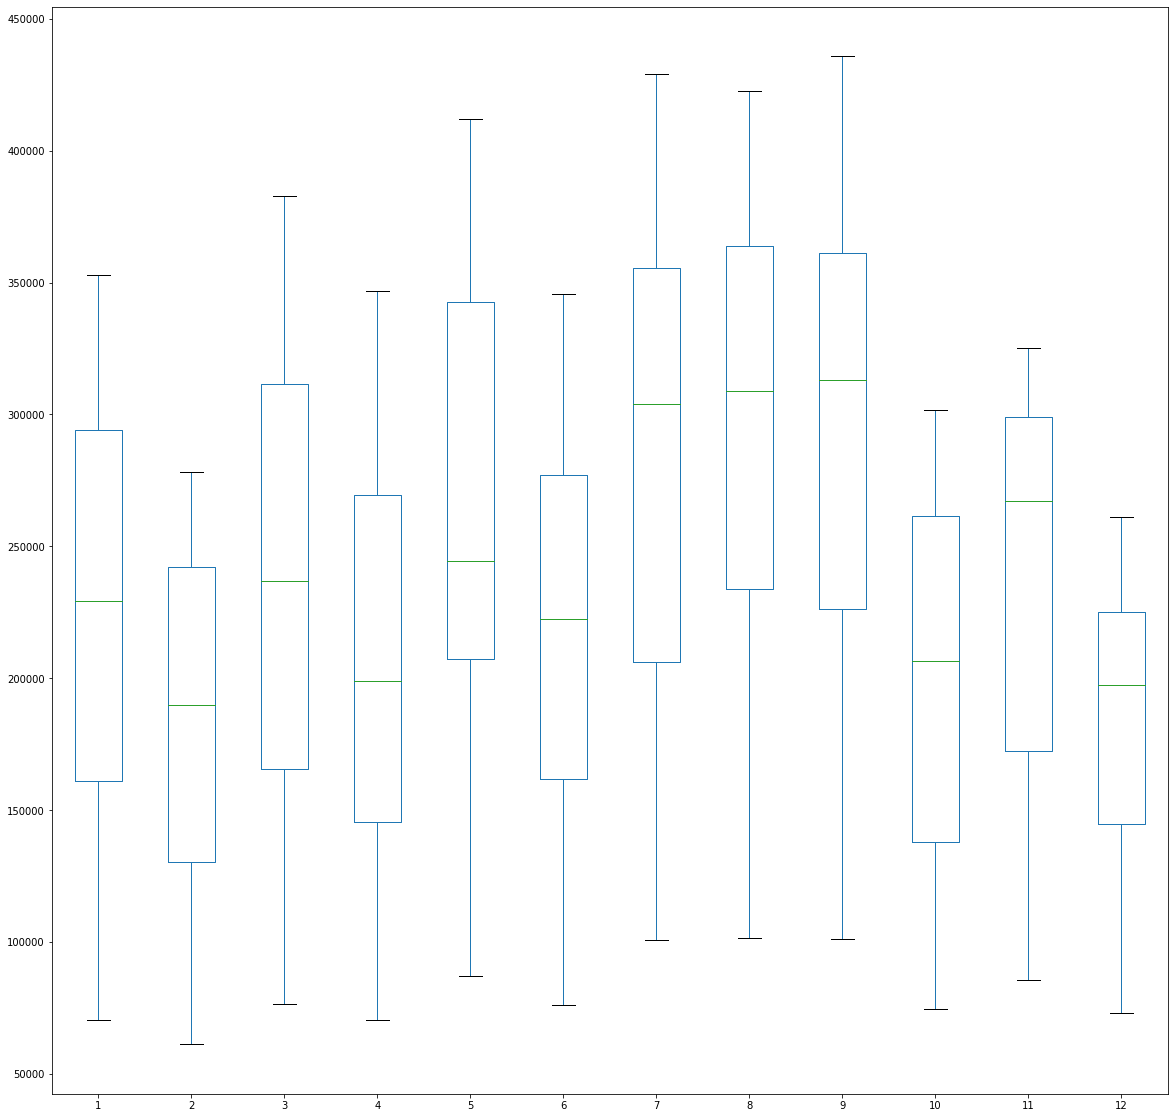

In [51]:
pivot_av_mod['Open Interest'].plot(figsize = (20,20),
                                  kind = 'box')

In [ ]:
plot_series(daily_mod, ['first_diff'], title = "First-Order Differenced Soybean Price")
plt.axline(0, color = 'red') #had 6 in example

In [52]:
recent = daily[daily['year']>2017]

In [53]:
recent = recent[recent['year']<2020]

Impact of US-China Tariffs on Soybean Price

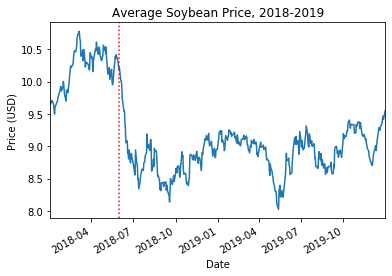

In [54]:
recent['Settlement Price'].plot()
plt.title('Average Soybean Price, 2018-2019')
plt.ylabel('Price (USD)')
plt.axvline('2018-06', color = 'r', ls = ':');

In [59]:
event = daily[daily['year']>2007]

In [60]:
event = event[event['year']<2010]

In [64]:
np.max(event['Settlement Price'])

16.31

In [67]:
np.min(event['Settlement Price'])

7.835

In [68]:
event[event['Settlement Price']==7.835]

,Last,Settlement Price,Change,% Change,Bid,Ask,Open Interest,Volume,month,day,year
Date,,,,,,,,,,,
2008-12-05,7.835,7.835,-0.275,-3.39,NaN,NaN,"126,531.000","101,361.000",12,5,2008


In [65]:
event[event['Settlement Price']==16.31]

,Last,Settlement Price,Change,% Change,Bid,Ask,Open Interest,Volume,month,day,year
Date,,,,,,,,,,,
2008-07-03,16.310,16.31,0.01,0.06,NaN,NaN,"272,366.000","61,393.000",7,3,2008


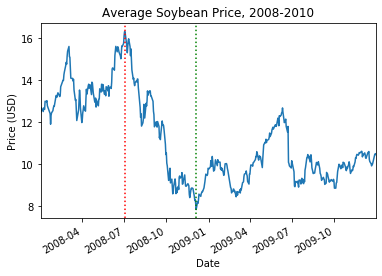

In [69]:
event['Settlement Price'].plot()
plt.title('Average Soybean Price, 2008-2010')
plt.ylabel('Price (USD)')
plt.axvline('2008-07-03', color = 'r', ls = ':')
plt.axvline('2008-12-05', color = 'g', ls = ':');

## EXOG FEATURES
Importing USDA Soybeans Production data.

In [75]:
import os

In [77]:
os.getcwd()

'/Users/andreayoss/Desktop/DSI_10/Capstone/EDA'

In [318]:
prod = pd.read_csv('../Data/USDA_Soybeans_Production.csv')

In [319]:
prod.head()

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,"SOYBEANS - CRUSHED, MEASURED IN TONS - <b>VALUE</b>","SOYBEANS - CRUSHED, MEASURED IN TONS - <b>CV (%)</b>","SOYBEANS - PRICE RECEIVED, MEASURED IN $ / BU - <b>VALUE</b>","SOYBEANS - PRICE RECEIVED, MEASURED IN $ / BU - <b>CV (%)</b>","SOYBEANS - PRODUCTION, MEASURED IN $ - <b>VALUE</b>","SOYBEANS - PRODUCTION, MEASURED IN $ - <b>CV (%)</b>","SOYBEANS - PRODUCTION, MEASURED IN BU - <b>VALUE</b>","SOYBEANS - PRODUCTION, MEASURED IN BU - <b>CV (%)</b>","SOYBEANS - YIELD, MEASURED IN BU / ACRE - <b>VALUE</b>","SOYBEANS - YIELD, MEASURED IN BU / ACRE - <b>CV (%)</b>"
0,SURVEY,2019,YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"31,202,680,000",NaN,"3,558,281,000",NaN,47.4,NaN
1,SURVEY,2018,YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,"62,971,231",NaN,9.15,NaN,"36,819,008,000",NaN,"4,428,150,000",NaN,50.6,NaN
2,SURVEY,2017,YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,"57,547,269",NaN,9.39,NaN,"41,308,740,000",NaN,"4,411,633,000",NaN,49.3,NaN
3,SURVEY,2016,YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,"57,079,294",NaN,9.39,NaN,"40,694,573,000",NaN,"4,296,496,000",NaN,51.9,NaN
4,SURVEY,2015,YEAR,NaN,NATIONAL,US TOTAL,NaN,NaN,NaN,NaN,...,NaN,NaN,9.49,NaN,"35,195,882,000",NaN,"3,926,779,000",NaN,48.0,NaN


In [320]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 32 columns):
Program                                                            96 non-null object
Year                                                               96 non-null int64
Period                                                             96 non-null object
Week Ending                                                        0 non-null float64
Geo Level                                                          96 non-null object
State                                                              96 non-null object
State ANSI                                                         0 non-null float64
Ag District                                                        0 non-null float64
Ag District Code                                                   0 non-null float64
County                                                             0 non-null float64
County ANSI                           

In [321]:
prod.isnull().sum().sort_values(ascending = False)

SOYBEANS - YIELD, MEASURED IN BU / ACRE  -  <b>CV (%)</b>          96
SOYBEANS - ACRES PLANTED  -  <b>CV (%)</b>                         96
Zip Code                                                           96
Region                                                             96
Ag District Code                                                   96
Watershed                                                          96
Ag District                                                        96
State ANSI                                                         96
SOYBEANS - ACRES HARVESTED  -  <b>CV (%)</b>                       96
County                                                             96
Week Ending                                                        96
SOYBEANS - CRUSHED, MEASURED IN TONS  -  <b>CV (%)</b>             96
SOYBEANS - PRICE RECEIVED, MEASURED IN $ / BU  -  <b>CV (%)</b>    96
SOYBEANS - PRODUCTION, MEASURED IN $  -  <b>CV (%)</b>             96
SOYBEANS - PRODUCTIO

In [322]:
prod.dropna(axis=1, inplace = True)

In [323]:
prod.isnull().sum().sort_values(ascending = False)

SOYBEANS - YIELD, MEASURED IN BU / ACRE  -  <b>VALUE</b>    0
SOYBEANS - PRODUCTION, MEASURED IN BU  -  <b>VALUE</b>      0
SOYBEANS - PRODUCTION, MEASURED IN $  -  <b>VALUE</b>       0
SOYBEANS - ACRES PLANTED  -  <b>VALUE</b>                   0
SOYBEANS - ACRES HARVESTED  -  <b>VALUE</b>                 0
Domain Category                                             0
Domain                                                      0
Commodity                                                   0
watershed_code                                              0
State                                                       0
Geo Level                                                   0
Period                                                      0
Year                                                        0
Program                                                     0
dtype: int64

In [324]:
prod.head()

,Program,Year,Period,Geo Level,State,watershed_code,Commodity,Domain,Domain Category,SOYBEANS - ACRES HARVESTED - <b>VALUE</b>,SOYBEANS - ACRES PLANTED - <b>VALUE</b>,"SOYBEANS - PRODUCTION, MEASURED IN $ - <b>VALUE</b>","SOYBEANS - PRODUCTION, MEASURED IN BU - <b>VALUE</b>","SOYBEANS - YIELD, MEASURED IN BU / ACRE - <b>VALUE</b>"
0,SURVEY,2019,YEAR,NATIONAL,US TOTAL,0,SOYBEANS,TOTAL,NOT SPECIFIED,"75,021,000","76,100,000","31,202,680,000","3,558,281,000",47.4
1,SURVEY,2018,YEAR,NATIONAL,US TOTAL,0,SOYBEANS,TOTAL,NOT SPECIFIED,"87,594,000","89,167,000","36,819,008,000","4,428,150,000",50.6
2,SURVEY,2017,YEAR,NATIONAL,US TOTAL,0,SOYBEANS,TOTAL,NOT SPECIFIED,"89,542,000","90,162,000","41,308,740,000","4,411,633,000",49.3
3,SURVEY,2016,YEAR,NATIONAL,US TOTAL,0,SOYBEANS,TOTAL,NOT SPECIFIED,"82,706,000","83,453,000","40,694,573,000","4,296,496,000",51.9
4,SURVEY,2015,YEAR,NATIONAL,US TOTAL,0,SOYBEANS,TOTAL,NOT SPECIFIED,"81,742,000","82,660,000","35,195,882,000","3,926,779,000",48.0


In [325]:
prod = prod[prod['Year']>1989]

In [326]:
prod.columns

Index(['Program', 'Year', 'Period', 'Geo Level', 'State', 'watershed_code',
       'Commodity', 'Domain', 'Domain Category',
       'SOYBEANS - ACRES HARVESTED  -  <b>VALUE</b>',
       'SOYBEANS - ACRES PLANTED  -  <b>VALUE</b>',
       'SOYBEANS - PRODUCTION, MEASURED IN $  -  <b>VALUE</b>',
       'SOYBEANS - PRODUCTION, MEASURED IN BU  -  <b>VALUE</b>',
       'SOYBEANS - YIELD, MEASURED IN BU / ACRE  -  <b>VALUE</b>'],
      dtype='object')

In [327]:
prod.drop(columns = ['Period', 'Geo Level', 'State', 'watershed_code',
       'Commodity', 'Domain', 'Domain Category','Program'], inplace = True)

In [328]:
prod.head()

,Year,SOYBEANS - ACRES HARVESTED - <b>VALUE</b>,SOYBEANS - ACRES PLANTED - <b>VALUE</b>,"SOYBEANS - PRODUCTION, MEASURED IN $ - <b>VALUE</b>","SOYBEANS - PRODUCTION, MEASURED IN BU - <b>VALUE</b>","SOYBEANS - YIELD, MEASURED IN BU / ACRE - <b>VALUE</b>"
0,2019,"75,021,000","76,100,000","31,202,680,000","3,558,281,000",47.4
1,2018,"87,594,000","89,167,000","36,819,008,000","4,428,150,000",50.6
2,2017,"89,542,000","90,162,000","41,308,740,000","4,411,633,000",49.3
3,2016,"82,706,000","83,453,000","40,694,573,000","4,296,496,000",51.9
4,2015,"81,742,000","82,660,000","35,195,882,000","3,926,779,000",48.0


In [329]:
prod.set_index('Year', inplace = True)

In [330]:
prod.sort_index(inplace = True)

In [331]:
prod.columns

Index(['SOYBEANS - ACRES HARVESTED  -  <b>VALUE</b>',
       'SOYBEANS - ACRES PLANTED  -  <b>VALUE</b>',
       'SOYBEANS - PRODUCTION, MEASURED IN $  -  <b>VALUE</b>',
       'SOYBEANS - PRODUCTION, MEASURED IN BU  -  <b>VALUE</b>',
       'SOYBEANS - YIELD, MEASURED IN BU / ACRE  -  <b>VALUE</b>'],
      dtype='object')

In [332]:
prod.rename(columns = {
    'SOYBEANS - ACRES HARVESTED  -  <b>VALUE</b>': 'Acres_Harvested',
    'SOYBEANS - ACRES PLANTED  -  <b>VALUE</b>': 'Acres_Planted',
    'SOYBEANS - PRODUCTION, MEASURED IN $  -  <b>VALUE</b>': 'Production_$',
    'SOYBEANS - PRODUCTION, MEASURED IN BU  -  <b>VALUE</b>': 'Production_BU',
    'SOYBEANS - YIELD, MEASURED IN BU / ACRE  -  <b>VALUE</b>': 'Yield_BU/Acre'
}, inplace = True)

In [333]:
prod.head()

,Acres_Harvested,Acres_Planted,Production_$,Production_BU,Yield_BU/Acre
Year,,,,,
1990,"56,512,000","57,795,000","11,042,010,000","1,925,947,000",34.1
1991,"58,011,000","59,180,000","11,091,996,000","1,986,539,000",34.2
1992,"58,233,000","59,180,000","12,167,564,000","2,190,354,000",37.6
1993,"57,307,000","60,085,000","11,941,449,000","1,869,718,000",32.6
1994,"60,809,000","61,620,000","13,746,071,000","2,514,869,000",41.4


In [334]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 1990 to 2019
Data columns (total 5 columns):
Acres_Harvested    30 non-null object
Acres_Planted      30 non-null object
Production_$       30 non-null object
Production_BU      30 non-null object
Yield_BU/Acre      30 non-null float64
dtypes: float64(1), object(4)
memory usage: 1.4+ KB


In [335]:
prod['Acres_Harvested'][1990].replace(',', '')

'56512000'

In [336]:
for year in prod.index:
    for col in ['Acres_Harvested', 'Acres_Planted', 'Production_$', 'Production_BU']:
        prod[col][year] = prod[col][year].replace(',', '')

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [337]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 1990 to 2019
Data columns (total 5 columns):
Acres_Harvested    30 non-null object
Acres_Planted      30 non-null object
Production_$       30 non-null object
Production_BU      30 non-null object
Yield_BU/Acre      30 non-null float64
dtypes: float64(1), object(4)
memory usage: 2.7+ KB


In [338]:
prod = prod.astype(float)

In [339]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 1990 to 2019
Data columns (total 5 columns):
Acres_Harvested    30 non-null float64
Acres_Planted      30 non-null float64
Production_$       30 non-null float64
Production_BU      30 non-null float64
Yield_BU/Acre      30 non-null float64
dtypes: float64(5)
memory usage: 2.7 KB


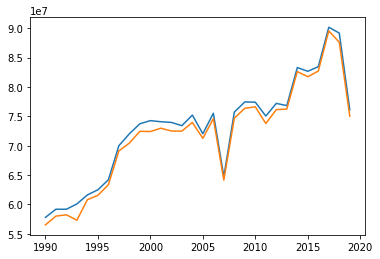

In [340]:
plt.plot(prod['Acres_Planted'])
plt.plot(prod['Acres_Harvested'])

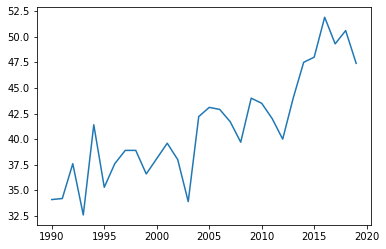

In [341]:
plt.plot(prod['Yield_BU/Acre'])

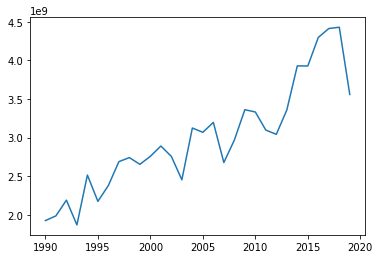

In [342]:
plt.plot(prod['Production_BU'])

### Precipitation Data- US Top Producing States

In [251]:
IA = pd.read_csv('../Data/NOAA_Iowa.csv')

In [252]:
IA.columns

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'PRCP',
       'PRCP_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES',
       'TOBS', 'TOBS_ATTRIBUTES', 'WT01', 'WT01_ATTRIBUTES', 'WT03',
       'WT03_ATTRIBUTES', 'WT04', 'WT04_ATTRIBUTES', 'WT05', 'WT05_ATTRIBUTES',
       'WT06', 'WT06_ATTRIBUTES', 'WT11', 'WT11_ATTRIBUTES'],
      dtype='object')

In [365]:
IA_prcp = IA[['DATE','PRCP', 'TMIN', 'TMAX']]
IA_prcp.head()

,DATE,PRCP,TMIN,TMAX
0,1990-01-01,0.00,19.0,32.0
1,1990-01-02,0.00,28.0,49.0
2,1990-01-03,0.00,35.0,45.0
3,1990-01-04,0.94,21.0,42.0
4,1990-01-05,0.00,18.0,40.0


In [366]:
IA_prcp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10788 entries, 0 to 10787
Data columns (total 4 columns):
DATE    10788 non-null object
PRCP    10770 non-null float64
TMIN    10748 non-null float64
TMAX    10748 non-null float64
dtypes: float64(3), object(1)
memory usage: 337.2+ KB


In [367]:
IA_prcp['DATE'] = pd.to_datetime(IA_prcp['DATE'])
IA_prcp.set_index('DATE', inplace=True)
IA_prcp.sort_index(inplace=True)
IA_prcp

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,PRCP,TMIN,TMAX
DATE,,,
1990-01-01,0.00,19.0,32.0
1990-01-02,0.00,28.0,49.0
1990-01-03,0.00,35.0,45.0
1990-01-04,0.94,21.0,42.0
1990-01-05,0.00,18.0,40.0
...,...,...,...
2019-12-27,0.00,32.0,37.0
2019-12-28,0.03,30.0,41.0
2019-12-29,0.77,38.0,54.0


In [370]:
IA_prcp.rename(columns = {'PRCP':'IA_PRCP',
                         'TMIN':'TMIN_IA',
                         'TMAX': 'TMAX_IA'}, inplace = True)

In [371]:
IA_prcp.columns

Index(['IA_PRCP', 'TMIN_IA', 'TMAX_IA'], dtype='object')

In [372]:
MN_IL = pd.read_csv('../Data/NOAA_MN_IL.csv')

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7,11,13,15,17,21,29,31,33,35,39,41,53,57,61) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [373]:
MN_IL.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,MDPR,MDPR_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,...,WT03,WT03_ATTRIBUTES,WT04,WT04_ATTRIBUTES,WT05,WT05_ATTRIBUTES,WT06,WT06_ATTRIBUTES,WT11,WT11_ATTRIBUTES
0,USC00215638,MORRIS WEST CENTRAL RESEARCH AND OUTREACH CENT...,45.5901,-95.8745,347.5,1990-01-01,NaN,NaN,0.01,",,0,0800",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00215638,MORRIS WEST CENTRAL RESEARCH AND OUTREACH CENT...,45.5901,-95.8745,347.5,1990-01-02,NaN,NaN,0.00,",,0,0800",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00215638,MORRIS WEST CENTRAL RESEARCH AND OUTREACH CENT...,45.5901,-95.8745,347.5,1990-01-03,NaN,NaN,0.00,",,0,0800",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00215638,MORRIS WEST CENTRAL RESEARCH AND OUTREACH CENT...,45.5901,-95.8745,347.5,1990-01-04,NaN,NaN,0.00,",,0,0800",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00215638,MORRIS WEST CENTRAL RESEARCH AND OUTREACH CENT...,45.5901,-95.8745,347.5,1990-01-05,NaN,NaN,0.00,",,0,0800",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [374]:
MN_IL.columns

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'MDPR',
       'MDPR_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES', 'SN01', 'SN01_ATTRIBUTES',
       'SN02', 'SN02_ATTRIBUTES', 'SN03', 'SN03_ATTRIBUTES', 'SN31',
       'SN31_ATTRIBUTES', 'SN32', 'SN32_ATTRIBUTES', 'SN33', 'SN33_ATTRIBUTES',
       'SN52', 'SN52_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES', 'SNWD',
       'SNWD_ATTRIBUTES', 'SX01', 'SX01_ATTRIBUTES', 'SX02', 'SX02_ATTRIBUTES',
       'SX03', 'SX03_ATTRIBUTES', 'SX31', 'SX31_ATTRIBUTES', 'SX32',
       'SX32_ATTRIBUTES', 'SX33', 'SX33_ATTRIBUTES', 'SX36', 'SX36_ATTRIBUTES',
       'SX52', 'SX52_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN',
       'TMIN_ATTRIBUTES', 'TOBS', 'TOBS_ATTRIBUTES', 'WT01', 'WT01_ATTRIBUTES',
       'WT03', 'WT03_ATTRIBUTES', 'WT04', 'WT04_ATTRIBUTES', 'WT05',
       'WT05_ATTRIBUTES', 'WT06', 'WT06_ATTRIBUTES', 'WT11',
       'WT11_ATTRIBUTES'],
      dtype='object')

In [364]:
MN_IL[['DATE', 'PRCP','TMIN', 'TMAX', 'MDPR']]

,DATE,TMIN,TMAX,MDPR
18252,2010-01-21,38.0,45.0,0.57


In [363]:
MN_IL[['DATE','TMIN', 'TMAX']]

,DATE,TMIN,TMAX,MDPR
0,1990-01-01,-3.0,24.0,NaN
1,1990-01-02,1.0,27.0,NaN
2,1990-01-03,19.0,32.0,NaN
3,1990-01-04,1.0,26.0,NaN
4,1990-01-05,11.0,20.0,NaN
...,...,...,...,...
21879,2019-12-27,39.0,48.0,NaN
21880,2019-12-28,41.0,63.0,NaN
21881,2019-12-29,42.0,64.0,NaN
21882,2019-12-30,35.0,42.0,NaN


In [375]:
MN_IL['NAME'].unique()

array(['MORRIS WEST CENTRAL RESEARCH AND OUTREACH CENTER, MN US',
       'BELLEVILLE SIU RESEARCH, IL US'], dtype=object)

In [376]:
MN_IL['STATION'].unique()

array(['USC00215638', 'USW00013802'], dtype=object)

In [377]:
MN_IL_prcp = MN_IL[['DATE', 'PRCP', 'STATION', 'TMIN', 'TMAX']]
MN_IL_prcp.head()

,DATE,PRCP,STATION,TMIN,TMAX
0,1990-01-01,0.01,USC00215638,-3.0,24.0
1,1990-01-02,0.00,USC00215638,1.0,27.0
2,1990-01-03,0.00,USC00215638,19.0,32.0
3,1990-01-04,0.00,USC00215638,1.0,26.0
4,1990-01-05,0.00,USC00215638,11.0,20.0


In [378]:
MN_IL_prcp['DATE'] = pd.to_datetime(MN_IL_prcp['DATE'])
MN_IL_prcp.set_index('DATE', inplace=True)
MN_IL_prcp.sort_index(inplace=True)
MN_IL_prcp

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,PRCP,STATION,TMIN,TMAX
DATE,,,,
1990-01-01,0.01,USC00215638,-3.0,24.0
1990-01-01,0.05,USW00013802,30.0,36.0
1990-01-02,0.00,USW00013802,25.0,45.0
1990-01-02,0.00,USC00215638,1.0,27.0
1990-01-03,0.00,USC00215638,19.0,32.0
...,...,...,...,...
2019-12-29,0.59,USW00013802,42.0,64.0
2019-12-30,0.38,USC00215638,16.0,33.0
2019-12-30,0.00,USW00013802,35.0,42.0


In [382]:
MN_prcp = MN_IL_prcp[MN_IL_prcp['STATION']=='USC00215638'].drop(columns = ['STATION'])
MN_prcp.rename(columns = {'PRCP':'MN_PRCP',
                          'TMIN':'TMIN_MN',
                         'TMAX': 'TMAX_MN'}, inplace = True)
IL_prcp = MN_IL_prcp[MN_IL_prcp['STATION']=='USW00013802'].drop(columns = ['STATION'])
IL_prcp.rename(columns = {'PRCP':'IL_PRCP',
                         'TMIN':'TMIN_IL',
                         'TMAX': 'TMAX_IL'}, inplace = True);

In [459]:
data = pd.concat([MN_prcp, IL_prcp, IA_prcp]).groupby('DATE').sum()
data

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,IA_PRCP,IL_PRCP,MN_PRCP,TMAX_IA,TMAX_IL,TMAX_MN,TMIN_IA,TMIN_IL,TMIN_MN
DATE,,,,,,,,,
1990-01-01,0.00,0.05,0.01,32.0,36.0,24.0,19.0,30.0,-3.0
1990-01-02,0.00,0.00,0.00,49.0,45.0,27.0,28.0,25.0,1.0
1990-01-03,0.00,0.00,0.00,45.0,49.0,32.0,35.0,32.0,19.0
1990-01-04,0.94,0.05,0.00,42.0,47.0,26.0,21.0,32.0,1.0
1990-01-05,0.00,0.00,0.00,40.0,38.0,20.0,18.0,16.0,11.0
...,...,...,...,...,...,...,...,...,...
2019-12-27,0.00,0.00,0.02,37.0,48.0,25.0,32.0,39.0,20.0
2019-12-28,0.03,0.46,0.06,41.0,63.0,30.0,30.0,41.0,15.0
2019-12-29,0.77,0.59,0.24,54.0,64.0,33.0,38.0,42.0,29.0


In [460]:
data.columns

Index(['IA_PRCP', 'IL_PRCP', 'MN_PRCP', 'TMAX_IA', 'TMAX_IL', 'TMAX_MN',
       'TMIN_IA', 'TMIN_IL', 'TMIN_MN'],
      dtype='object')

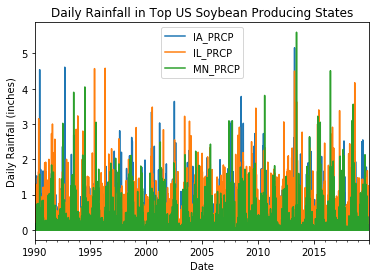

In [461]:
data.drop(columns = ['TMAX_IA', 'TMAX_IL', 'TMAX_MN',
       'TMIN_IA', 'TMIN_IL', 'TMIN_MN']).plot() 
plt.xlabel('Date')
plt.ylabel('Daily Rainfall (inches)')
plt.title('Daily Rainfall in Top US Soybean Producing States');

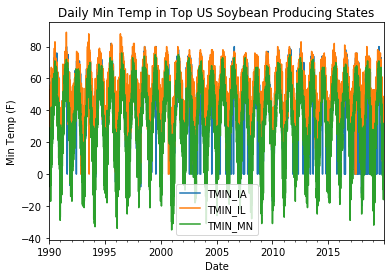

In [462]:
data.drop(columns = ['IA_PRCP', 'IL_PRCP', 'MN_PRCP', 'TMAX_IA', 'TMAX_IL', 'TMAX_MN']).plot() 
plt.xlabel('Date')
plt.ylabel('Min Temp (F)')
plt.title('Daily Min Temp in Top US Soybean Producing States');

In [463]:
data.mean()

IA_PRCP     0.098790
IL_PRCP     0.116910
MN_PRCP     0.073847
TMAX_IA    59.100392
TMAX_IL    68.335311
TMAX_MN    52.366797
TMIN_IA    39.326367
TMIN_IL    46.519759
TMIN_MN    32.476225
dtype: float64

In [464]:
total = []
average = []
for day in data.index:
    tot = round(data['IA_PRCP'][day] + data['MN_PRCP'][day] + data['IL_PRCP'][day],2)
    av = round(tot/3, 2)
    total.append(tot)
    average.append(av)

In [392]:
daily_price = daily[daily.index<'2020-01-01']['Settlement Price']

In [465]:
data['Settlement Price'] = daily_price

In [466]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10957 entries, 1990-01-01 to 2019-12-31
Data columns (total 10 columns):
IA_PRCP             10957 non-null float64
IL_PRCP             10957 non-null float64
MN_PRCP             10957 non-null float64
TMAX_IA             10957 non-null float64
TMAX_IL             10957 non-null float64
TMAX_MN             10957 non-null float64
TMIN_IA             10957 non-null float64
TMIN_IL             10957 non-null float64
TMIN_MN             10957 non-null float64
Settlement Price    7559 non-null float64
dtypes: float64(10)
memory usage: 1.2 MB


In [467]:
data.dropna(inplace = True)

In [468]:
data['IA_prcp_lag_1'] = data['IA_PRCP'].shift(1)
data['IL_prcp_lag_1'] = data['IL_PRCP'].shift(1)
data['MN_prcp_lag_1'] = data['MN_PRCP'].shift(1)

data['IA_TMIN_lag_1'] = data['TMIN_IA'].shift(1)
data['IL_TMIN_lag_1'] = data['TMIN_IL'].shift(1)
data['MN_TMIN_lag_1'] = data['TMIN_MN'].shift(1)
data['IA_TMIN_lag_360'] = data['TMIN_IA'].shift(360)
data['IL_TMIN_lag_360'] = data['TMIN_IL'].shift(360)
data['MN_TMIN_lag_360'] = data['TMIN_MN'].shift(360)

data['IA_TMAX_lag_1'] = data['TMAX_IA'].shift(1)
data['IL_TMAX_lag_1'] = data['TMAX_IL'].shift(1)
data['MN_TMAX_lag_1'] = data['TMAX_MN'].shift(1)
data['IA_TMAX_lag_360'] = data['TMAX_IA'].shift(360)
data['IL_TMAX_lag_360'] = data['TMAX_IL'].shift(360)
data['MN_TMAX_lag_360'] = data['TMAX_MN'].shift(360)


In [469]:
data

,IA_PRCP,IL_PRCP,MN_PRCP,TMAX_IA,TMAX_IL,TMAX_MN,TMIN_IA,TMIN_IL,TMIN_MN,Settlement Price,...,MN_TMIN_lag_1,IA_TMIN_lag_360,IL_TMIN_lag_360,MN_TMIN_lag_360,IA_TMAX_lag_1,IL_TMAX_lag_1,MN_TMAX_lag_1,IA_TMAX_lag_360,IL_TMAX_lag_360,MN_TMAX_lag_360
DATE,,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.00,0.00,0.00,49.0,45.0,27.0,28.0,25.0,1.0,5.613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,0.00,0.00,0.00,45.0,49.0,32.0,35.0,32.0,19.0,5.673,...,1.0,NaN,NaN,NaN,49.0,45.0,27.0,NaN,NaN,NaN
1990-01-04,0.94,0.05,0.00,42.0,47.0,26.0,21.0,32.0,1.0,5.633,...,19.0,NaN,NaN,NaN,45.0,49.0,32.0,NaN,NaN,NaN
1990-01-05,0.00,0.00,0.00,40.0,38.0,20.0,18.0,16.0,11.0,5.645,...,1.0,NaN,NaN,NaN,42.0,47.0,26.0,NaN,NaN,NaN
1990-01-08,0.00,0.00,0.00,43.0,50.0,40.0,31.0,21.0,16.0,5.707,...,11.0,NaN,NaN,NaN,40.0,38.0,20.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.00,0.00,0.00,53.0,57.0,32.0,27.0,26.0,22.0,9.365,...,19.0,67.0,67.0,62.0,45.0,56.0,35.0,86.0,96.0,68.0
2019-12-26,0.00,0.01,0.01,62.0,68.0,33.0,32.0,46.0,22.0,9.465,...,22.0,62.0,68.0,63.0,53.0,57.0,32.0,78.0,86.0,80.0
2019-12-27,0.00,0.00,0.02,37.0,48.0,25.0,32.0,39.0,20.0,9.415,...,22.0,65.0,60.0,58.0,62.0,68.0,33.0,84.0,89.0,79.0


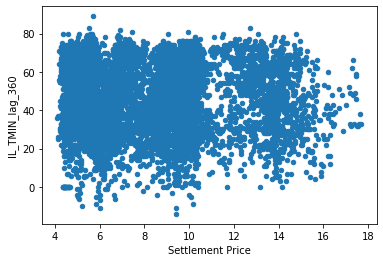

In [470]:
data.dropna().plot('Settlement Price', 'IL_TMIN_lag_360', kind = 'scatter')

In [429]:
prod.columns

Index(['Acres_Harvested', 'Acres_Planted', 'Production_$', 'Production_BU',
       'Yield_BU/Acre', 'Yield_lag_1'],
      dtype='object')

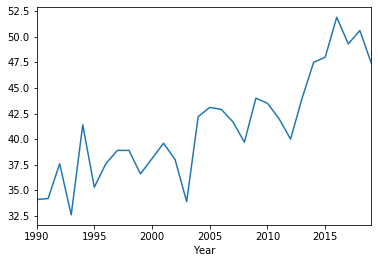

In [345]:
prod['Yield_BU/Acre'].plot()

In [346]:
prod['Yield_lag_1'] = prod['Yield_BU/Acre'].shift(1)

In [347]:
prod.head()

,Acres_Harvested,Acres_Planted,Production_$,Production_BU,Yield_BU/Acre,Yield_lag_1
Year,,,,,,
1990,56512000.0,57795000.0,1.104201e+10,1.925947e+09,34.1,NaN
1991,58011000.0,59180000.0,1.109200e+10,1.986539e+09,34.2,34.1
1992,58233000.0,59180000.0,1.216756e+10,2.190354e+09,37.6,34.2
1993,57307000.0,60085000.0,1.194145e+10,1.869718e+09,32.6,37.6
1994,60809000.0,61620000.0,1.374607e+10,2.514869e+09,41.4,32.6


In [448]:
prod.index

Int64Index([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
            2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
            2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
           dtype='int64', name='Year')

US — planting in late April through June, harvesting in late September through the end of November. So I will make the assumption that knowledge is stepwise, and that during the planting and harvesting seasons, the model witll  only know what has occured in prior events/ seasons. For example, in November, will not have harvest data for that season, but will have the production data.

In [423]:
#data['Month'] = data.index.month
#data['Year'] = data.index.year

In [451]:
#yr_ct = prcp['Year'].value_counts()
#yr_ct.sort_index(inplace=True)
#year = yr_ct.index

test = []
for yr in year:
    for ct in yr_ct:
        test.append[prod[]]
            

In [472]:
data.to_csv('../data/data_concat.csv')